In [1]:
# Basic imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import warnings
import torchvision.utils as vutils
import numpy as np

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Simplified hyperparameters
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS = 1  # Grayscale
LATENT_DIM = 100
EPOCHS = 30
LR = 2e-4

# Data loading
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=CHANNELS),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=CHANNELS),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.ImageFolder(
    "D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/train",
    transform=transform
)

train_loader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_data = datasets.ImageFolder(
    "D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/validation",
    transform=val_transform
)

val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [3]:
# Simplified Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is latent vector
            nn.ConvTranspose2d(LATENT_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Simplified Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 64x64 -> 32x32
            nn.Conv2d(CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 32x32 -> 16x16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 16x16 -> 8x8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 8x8 -> 4x4
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 4x4 -> 1x1
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [4]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Setup optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# Training function
# First, modify the train_epoch function to return accuracy:
def train_epoch(generator, discriminator, dataloader, g_optimizer, d_optimizer, criterion):
    g_losses = []
    d_losses = []
    correct_real = 0
    correct_fake = 0
    total = 0
    
    for real_images, _ in tqdm(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Train Discriminator
        d_optimizer.zero_grad()
        label_real = torch.ones(batch_size, 1, 1, 1).to(device)
        label_fake = torch.zeros(batch_size, 1, 1, 1).to(device)
        
        output_real = discriminator(real_images)
        d_loss_real = criterion(output_real, label_real)
        
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(output_fake, label_fake)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        output_fake = discriminator(fake_images)
        g_loss = criterion(output_fake, label_real)
        g_loss.backward()
        g_optimizer.step()
        
        # Calculate accuracy
        pred_real = (output_real > 0.5).float()
        pred_fake = (output_fake > 0.5).float()
        correct_real += (pred_real == label_real).sum().item()
        correct_fake += (pred_fake == label_fake).sum().item()
        total += batch_size * 2
        
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
    
    accuracy = 100 * (correct_real + correct_fake) / total
    return np.mean(g_losses), np.mean(d_losses), accuracy

In [5]:
# Add evaluation function
def evaluate(generator, discriminator, dataloader, criterion, device):
    generator.eval()
    discriminator.eval()
    g_losses = []
    d_losses = []
    correct_real = 0
    correct_fake = 0
    total = 0
    
    with torch.no_grad():
        for real_images, _ in dataloader:
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Labels for loss calculation
            label_real = torch.ones(batch_size, 1, 1, 1).to(device)
            label_fake = torch.zeros(batch_size, 1, 1, 1).to(device)
            
            # Evaluate on real images
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)
            
            # Generate and evaluate fake images
            noise = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images)
            
            d_loss_fake = criterion(output_fake, label_fake)
            g_loss = criterion(output_fake, label_real)
            
            # Calculate accuracy
            pred_real = (output_real > 0.5).float()
            pred_fake = (output_fake > 0.5).float()
            correct_real += (pred_real == label_real).sum().item()
            correct_fake += (pred_fake == label_fake).sum().item()
            total += batch_size * 2  # Both real and fake images
            
            g_losses.append(g_loss.item())
            d_losses.append((d_loss_real + d_loss_fake).item())
    
    avg_g_loss = np.mean(g_losses)
    avg_d_loss = np.mean(d_losses)
    accuracy = 100 * (correct_real + correct_fake) / total
    
    return avg_g_loss, avg_d_loss, accuracy

In [6]:
# Modify the training loop to include evaluation
os.makedirs("gan_images", exist_ok=True)
train_g_losses, train_d_losses = [], []
train_accuracies = []  # Add this line
val_g_losses, val_d_losses = [], []
val_accuracies = []
best_val_acc = 0

for epoch in range(EPOCHS):
    # Training
    generator.train()
    discriminator.train()
    g_loss, d_loss, train_acc = train_epoch(  # Modified to capture train_acc
        generator, discriminator, train_loader,
        g_optimizer, d_optimizer, criterion
    )
    train_g_losses.append(g_loss)
    train_d_losses.append(d_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    val_g_loss, val_d_loss, val_acc = evaluate(
        generator, discriminator, val_loader, criterion, device
    )
    val_g_losses.append(val_g_loss)
    val_d_losses.append(val_d_loss)
    val_accuracies.append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'g_optimizer_state_dict': g_optimizer.state_dict(),
            'd_optimizer_state_dict': d_optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'gan_images/best_model.pth')
    
    # Print metrics
    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train - G_loss: {g_loss:.4f}, D_loss: {d_loss:.4f}")
    print(f"Val - G_loss: {val_g_loss:.4f}, D_loss: {val_d_loss:.4f}, Acc: {val_acc:.2f}%")
    
    # Generate and save sample images
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake = generator(torch.randn(64, LATENT_DIM, 1, 1, device=device))
            vutils.save_image(fake, f"gan_images/fake_epoch_{epoch+1}.png", normalize=True)


100%|██████████| 451/451 [03:32<00:00,  2.12it/s]


Epoch [1/30]
Train - G_loss: 6.1798, D_loss: 0.5642
Val - G_loss: 0.3867, D_loss: 2.0328, Acc: 56.61%


100%|██████████| 451/451 [00:15<00:00, 28.83it/s]


Epoch [2/30]
Train - G_loss: 3.2983, D_loss: 0.7449
Val - G_loss: 0.8952, D_loss: 1.5061, Acc: 58.10%


100%|██████████| 451/451 [00:15<00:00, 28.89it/s]


Epoch [3/30]
Train - G_loss: 3.3500, D_loss: 0.6718
Val - G_loss: 2.0518, D_loss: 0.9267, Acc: 78.23%


100%|██████████| 451/451 [00:15<00:00, 28.80it/s]


Epoch [4/30]
Train - G_loss: 3.4578, D_loss: 0.6286
Val - G_loss: 1.8424, D_loss: 1.3946, Acc: 66.01%


100%|██████████| 451/451 [00:15<00:00, 28.80it/s]


Epoch [5/30]
Train - G_loss: 3.6363, D_loss: 0.5590
Val - G_loss: 2.4036, D_loss: 1.4366, Acc: 60.49%


100%|██████████| 451/451 [00:15<00:00, 28.71it/s]


Epoch [6/30]
Train - G_loss: 3.8013, D_loss: 0.5628
Val - G_loss: 2.1120, D_loss: 1.5975, Acc: 58.22%


100%|██████████| 451/451 [00:15<00:00, 28.73it/s]


Epoch [7/30]
Train - G_loss: 3.9177, D_loss: 0.5605
Val - G_loss: 2.3251, D_loss: 0.8188, Acc: 80.92%


100%|██████████| 451/451 [00:15<00:00, 29.22it/s]


Epoch [8/30]
Train - G_loss: 4.2618, D_loss: 0.4279
Val - G_loss: 3.4953, D_loss: 2.4040, Acc: 51.86%


100%|██████████| 451/451 [00:15<00:00, 28.84it/s]


Epoch [9/30]
Train - G_loss: 3.9593, D_loss: 0.5501
Val - G_loss: 1.4019, D_loss: 0.7942, Acc: 81.54%


100%|██████████| 451/451 [00:15<00:00, 28.68it/s]


Epoch [10/30]
Train - G_loss: 5.4605, D_loss: 0.2949
Val - G_loss: 2.0845, D_loss: 1.2333, Acc: 68.84%


100%|██████████| 451/451 [00:15<00:00, 29.05it/s]


Epoch [11/30]
Train - G_loss: 4.7969, D_loss: 0.3459
Val - G_loss: 2.1500, D_loss: 1.3385, Acc: 66.11%


100%|██████████| 451/451 [00:15<00:00, 28.83it/s]


Epoch [12/30]
Train - G_loss: 4.8864, D_loss: 0.3148
Val - G_loss: 2.7266, D_loss: 1.8819, Acc: 55.73%


100%|██████████| 451/451 [00:15<00:00, 28.82it/s]


Epoch [13/30]
Train - G_loss: 4.5238, D_loss: 0.3895
Val - G_loss: 3.1290, D_loss: 1.7885, Acc: 56.00%


100%|██████████| 451/451 [00:15<00:00, 28.84it/s]


Epoch [14/30]
Train - G_loss: 4.4999, D_loss: 0.4161
Val - G_loss: 1.6874, D_loss: 0.9816, Acc: 76.34%


100%|██████████| 451/451 [00:15<00:00, 28.80it/s]


Epoch [15/30]
Train - G_loss: 4.4727, D_loss: 0.3672
Val - G_loss: 1.7808, D_loss: 0.7584, Acc: 83.80%


100%|██████████| 451/451 [00:15<00:00, 28.80it/s]


Epoch [16/30]
Train - G_loss: 5.0052, D_loss: 0.2593
Val - G_loss: 2.8507, D_loss: 2.0399, Acc: 55.23%


100%|██████████| 451/451 [00:15<00:00, 28.89it/s]


Epoch [17/30]
Train - G_loss: 4.9270, D_loss: 0.2824
Val - G_loss: 2.9866, D_loss: 1.0090, Acc: 74.50%


100%|██████████| 451/451 [00:15<00:00, 28.85it/s]


Epoch [18/30]
Train - G_loss: 4.9417, D_loss: 0.3159
Val - G_loss: 2.6574, D_loss: 1.7429, Acc: 61.62%


100%|██████████| 451/451 [00:15<00:00, 29.04it/s]


Epoch [19/30]
Train - G_loss: 5.2344, D_loss: 0.2300
Val - G_loss: 3.3355, D_loss: 1.6886, Acc: 59.69%


100%|██████████| 451/451 [00:15<00:00, 28.86it/s]


Epoch [20/30]
Train - G_loss: 4.9808, D_loss: 0.3351
Val - G_loss: 2.9482, D_loss: 1.6538, Acc: 60.87%


100%|██████████| 451/451 [00:15<00:00, 29.06it/s]


Epoch [21/30]
Train - G_loss: 5.3713, D_loss: 0.2262
Val - G_loss: 2.3935, D_loss: 1.7615, Acc: 60.56%


100%|██████████| 451/451 [00:15<00:00, 28.80it/s]


Epoch [22/30]
Train - G_loss: 4.4512, D_loss: 0.4175
Val - G_loss: 1.7076, D_loss: 1.7900, Acc: 55.90%


100%|██████████| 451/451 [00:15<00:00, 28.96it/s]


Epoch [23/30]
Train - G_loss: 4.5050, D_loss: 0.3125
Val - G_loss: 1.9910, D_loss: 0.7297, Acc: 84.08%


100%|██████████| 451/451 [00:15<00:00, 28.86it/s]


Epoch [24/30]
Train - G_loss: 4.9950, D_loss: 0.2620
Val - G_loss: 3.4371, D_loss: 1.2485, Acc: 68.74%


100%|██████████| 451/451 [00:15<00:00, 28.92it/s]


Epoch [25/30]
Train - G_loss: 5.4485, D_loss: 0.2671
Val - G_loss: 1.9391, D_loss: 0.8361, Acc: 80.77%


100%|██████████| 451/451 [00:15<00:00, 28.96it/s]


Epoch [26/30]
Train - G_loss: 4.7161, D_loss: 0.2792
Val - G_loss: 2.4733, D_loss: 1.4442, Acc: 65.02%


100%|██████████| 451/451 [00:15<00:00, 28.93it/s]


Epoch [27/30]
Train - G_loss: 5.4790, D_loss: 0.2252
Val - G_loss: 2.2557, D_loss: 0.8037, Acc: 82.27%


100%|██████████| 451/451 [00:15<00:00, 29.29it/s]


Epoch [28/30]
Train - G_loss: 4.6758, D_loss: 0.2916
Val - G_loss: 2.5024, D_loss: 1.1574, Acc: 71.94%


100%|██████████| 451/451 [00:15<00:00, 29.19it/s]


Epoch [29/30]
Train - G_loss: 4.8911, D_loss: 0.2658
Val - G_loss: 2.5520, D_loss: 1.2065, Acc: 70.81%


100%|██████████| 451/451 [00:15<00:00, 28.72it/s]


Epoch [30/30]
Train - G_loss: 6.2078, D_loss: 0.1014
Val - G_loss: 5.0951, D_loss: 1.3060, Acc: 70.07%


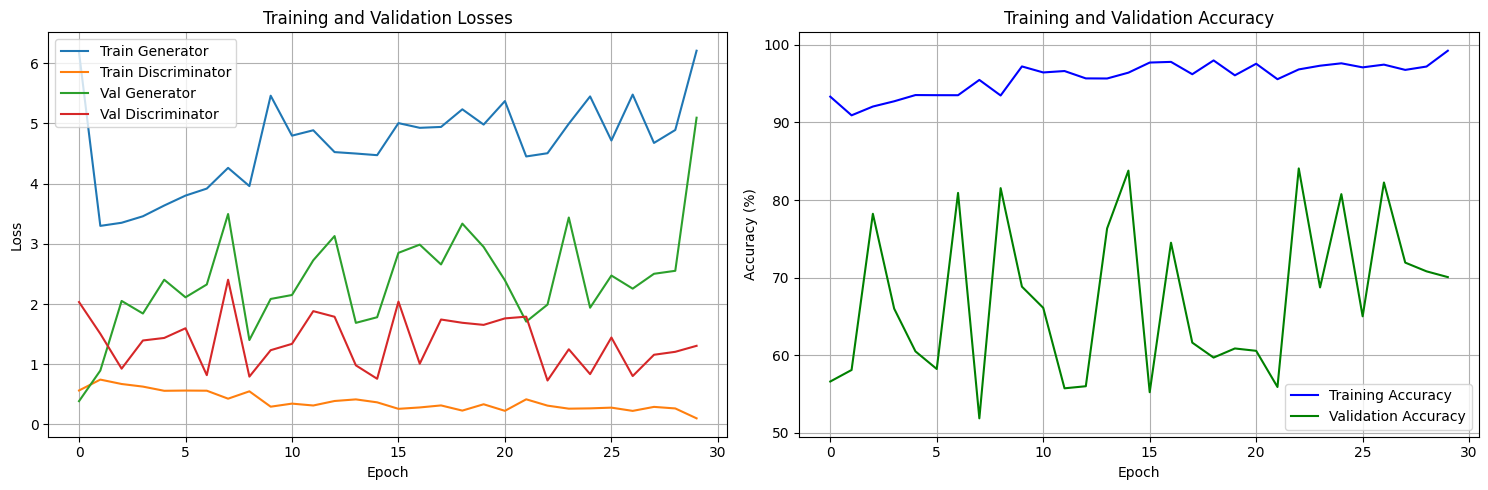

In [7]:
# Update the plotting code:
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_g_losses, label='Train Generator')
plt.plot(train_d_losses, label='Train Discriminator')
plt.plot(val_g_losses, label='Val Generator')
plt.plot(val_d_losses, label='Val Discriminator')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')  # Add training accuracy
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('gan_images/training_history.png')
plt.show()